In [1]:
from util.trajectories import *
from util.guided_ot import * 
from util.simplicial_paths import *

# Functions

In [2]:
def dijkstra_tree(SC, best_path, other_paths, ref_path_class, colors=['green', 'red', 'blue'], plot_others=False, figsize=(5,5)):
    shortest_class = Trajectory_Class(SC)
    shortest_class.add_path(best_path)
    other_class = Trajectory_Class(SC)

    for path in other_paths:
        other_class.add_path(path)

    holder = Trajectory_Holder(SC)

    if plot_others:
        holder.add_class(other_class, None, 'others', colors[0])
        
    holder.add_class(ref_path_class, None, 'reference', colors[1])
    holder.add_class(shortest_class, None, 'result', colors[2])

    holder.plot_paths(True, figsize=figsize)
    holder.plot_projections(figsize=figsize)
    plt.show()

    return holder

def backtrace(prev, start, end):
    node = end
    path = []
    while node != start:
        path.append(node)
        node = prev[node]
    path.append(node) 
    path.reverse()
    return path

def get_node_weights(path):
    return path.path_length

def get_path_proj_diff(path, ref_proj, norm_type=1):
    return np.linalg.norm(path.edge_projections - ref_proj, norm_type, axis=1)

def compute_costs(path, ref_proj, alpha, norm_type):
    edge_weights = np.hstack([np.array([0]), get_node_weights(path)])
    proj_diffs = get_path_proj_diff(path, ref_proj, norm_type)
    return edge_weights, proj_diffs, edge_weights + alpha * proj_diffs

def compare_path_perf(path1, path2, ref_proj, alpha, norm_type=1):
    num_nodes_path1, num_nodes_path2 = len(path1.nodes), len(path2.nodes)
    len_diff = np.abs(num_nodes_path1 - num_nodes_path2)
    shorter_path = np.argmin([ num_nodes_path1, num_nodes_path2 ])
    path1_costs = compute_costs(path1, ref_proj, alpha, norm_type)
    path2_costs = compute_costs(path2, ref_proj, alpha, norm_type)
    
    if len_diff == 0:
        return path1_costs, path2_costs
    elif shorter_path == 0:
        edge_cost = np.ones(num_nodes_path2) * path1_costs[0][-1]
        edge_cost[:num_nodes_path1] = path1_costs[0]

        proj_cost = np.ones(num_nodes_path2) * path1_costs[1][-1]
        proj_cost[:num_nodes_path1] = path1_costs[1]

        total_cost = np.ones(num_nodes_path2) * path1_costs[2][-1]
        total_cost[:num_nodes_path1] = path1_costs[2]

        path1_costs = edge_cost, proj_cost, total_cost
    else:
        edge_cost = np.ones(num_nodes_path1) * path2_costs[0][-1]
        edge_cost[:num_nodes_path2] = path2_costs[0]

        proj_cost = np.ones(num_nodes_path1) * path2_costs[1][-1]
        proj_cost[:num_nodes_path2] = path2_costs[1]

        total_cost = np.ones(num_nodes_path1) * path2_costs[2][-1]
        total_cost[:num_nodes_path2] = path2_costs[2]

        path2_costs = edge_cost, proj_cost, total_cost

    return path1_costs, path2_costs

def plot_cost_diffs(path1, path2, ref_path_proj, alpha, norm_type=1):
    path1_costs, path2_costs = compare_path_perf(path1, path2, ref_path_proj, alpha, norm_type)
    #print(path1_costs[0].shape, path1_costs[1].shape, path1_costs[2].shape)
    #print(path2_costs[0].shape, path2_costs[1].shape, path2_costs[2].shape)
    fig, ax = plt.subplots(3,1, figsize=(12,36))#,12))

    colors = ["red", "blue"]

    x_axis = np.arange(np.max([len(path1.nodes), len(path2.nodes)]))

    ax[0].plot(x_axis, path1_costs[0], color=colors[0], marker="+")
    ax[0].plot(x_axis, path2_costs[0], color=colors[1], marker="x")
    ax[0].set_xlabel('Path node')
    ax[0].set_ylabel('Edge weight sum')
    ax[0].legend(["reference path", "resulting path"])

    ax[1].plot(x_axis, path1_costs[1], color=colors[0], marker="1")
    ax[1].plot(x_axis, path2_costs[1], color=colors[1], marker="2")
    ax[1].set_xlabel('Path node')
    ax[1].set_ylabel('Projection difference')
    ax[1].legend(["reference path", "resulting path"])

    #ax[2].scatter(x_axis, path1_costs[0], color=colors[0], marker="+")
    #ax[2].scatter(x_axis, path2_costs[0], color=colors[1], marker="x")
    #ax[2].scatter(x_axis, alpha * path1_costs[1],  color=colors[0], marker="1")
    #ax[2].scatter(x_axis, alpha * path2_costs[1], color=colors[1], marker="2")
    ax[2].plot(x_axis, path1_costs[2], color=colors[0], marker="*")
    ax[2].plot(x_axis, path2_costs[2], color=colors[1], marker="P")

    ax[2].set_xlabel('Path node')
    ax[2].set_ylabel('Total cost = edge weight sum + alpha * proj diff') 
    ax[2].legend(["reference path", "resulting path"])
    plt.show()

def plot_bases(SC, extra):
    node_pos = {i:SC.nodes[i] for i in (np.where(SC.node_vec == 1)[0])}
    num_bases = SC.H_extra.shape[0] if extra else SC.H.shape[0]
    for i in range(num_bases):
        harm_vec = SC.H_extra[i,:]
        harm_vec_sign = np.sign(harm_vec)
        harm_vec_weight = np.abs(harm_vec)
        G = SC.graph
        GG = nx.DiGraph()
        G_oriented = nx.DiGraph()
        j = 0
        for k, edge in enumerate(SC.edges):
            if not SC.edge_vec[k]:
                continue
            sign, weight = harm_vec_sign[j], harm_vec_weight[j] * 10
            oriented_edge = (edge[0], edge[1]) if (sign > 0) else (edge[1], edge[0])
            G_oriented.add_edge(oriented_edge[0], oriented_edge[1], weight=weight)
            GG.add_edge(edge[0], edge[1], weight=weight)
            j += 1

        oriented_weights = [G_oriented[u][v]['weight'] for u,v in G_oriented.edges]

        plt.figure(figsize=(12,12))
        nx.draw(G_oriented, pos=node_pos, node_size=5, node_color='gray', width=oriented_weights, edge_color='black', arrows=True, arrowstyle="-|>", arrowsize=[8.5 * i for i in oriented_weights])
        plt.title(f"Basis corresponding to coordinate {i+1}")
        plt.show()

colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
colors = ['#377eb8', 'red', 'green']

# Homologous, but not homotopic paths

In [ ]:
n_side, point_gen_mode = 15, 0

r1, r2 = 0.5, 0.2
n_holes = 3
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]

# Initialize Simplicial Complex (SC)

pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
#plt.figure(figsize=(6,6))
#SC.plot()

In [ ]:
plot_bases(SC, False)

In [ ]:
ref_path_coords = [(-1,-1), (1, -1), (1,-0.5), (-1, -0.5), (-1, 0.5), (0,0), (1,0), (1,1)]
num_paths, num_nodes = 1, 1

ref_path_class = Trajectory_Class(SC)
ref_path_class.generate_paths(ref_path_coords, num_paths, num_nodes, 1e-1)
ref_path = ref_path_class.paths[0]
ref_path_class.plot_paths('red', 'ref', figsize=(12,12))
ref_path_proj = ref_path.edge_projections[-1]

In [ ]:
ref_path_proj = ref_path.edge_projections[-1]

start, end = 0, len(SC.node_vec)-1
#alpha = 100

alphas = np.arange(0, 1.1, 0.2)
#alphas = np.hstack([alphas, [100, 1000]])
alphas = [10, 100]
holders = []

for alpha in alphas:
    best_path, cost, prev, visit_order, other_paths = augmented_dijkstra(SC, start, end, ref_path_proj, alpha, False)
    print(f"Alpha = {alpha},  final cost = {cost}")
    print(f"ref proj : {ref_path_proj}, path proj : {best_path.edge_projections[-1]}")
    holder = dijkstra_tree(SC, best_path, other_paths, ref_path_class)
    plot_cost_diffs(ref_path, best_path, ref_path_proj, alpha)
    holders.append(holder)
    print("--*---*"*15)


# Another example of homologous, but not homotopic paths

In [ ]:
n_side, point_gen_mode = 19, 0

r1, r2 = 0.6, 0.15
n_holes = 4
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
SC.plot()

In [ ]:
path1_coords = [(-1,-1), (1, -1), (1, 0), (-1, 0), (-1, 1), (1,1)]
num_paths, num_nodes = 1, 1

ref_path_class = Trajectory_Class(SC)
ref_path_class.generate_paths(path1_coords, num_paths, num_nodes, 1e-1)
ref_path = ref_path_class.paths[0]
ref_path_class.plot_paths('red', 'path1')

In [ ]:
ref_path_proj = ref_path.edge_projections[-1]

start, end = 0, len(SC.node_vec)-1

alphas = np.arange(0, 1.1, 0.1)
alphas = np.hstack([alphas, [100, 1000]])
holders = []

for alpha in alphas:
    best_path, cost, prev, visit_order, other_paths = augmented_dijkstra(SC, start, end, ref_path_proj, alpha, False)
    print(f"Alpha = {alpha},  final cost = {cost}")
    print(f"ref proj : {ref_path_proj}, path proj : {best_path.edge_projections[-1]}")
    holder = dijkstra_tree(SC, best_path, other_paths, ref_path_class)
    plot_cost_diffs(ref_path, best_path, ref_path_proj, alpha)
    holders.append(holder)
    print("--*---*"*15)

# Another example of homologous, but not homotopic paths

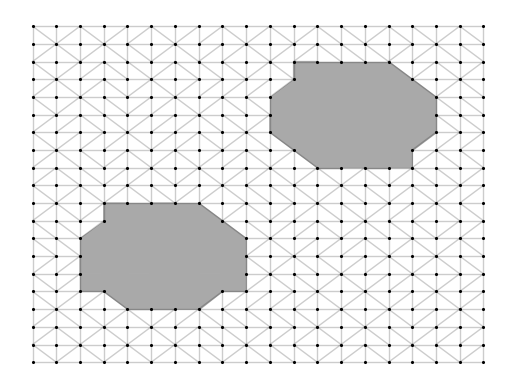

In [3]:
n_side, point_gen_mode = 20, 0

r1, r2 = 0.6, 0.3
n_holes = 2
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]
hole_locs += np.array([0.0, 0.05])

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0
start, end = 0, len(SC.node_vec)-1

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
SC.plot()

EXTRA: False
DIM PROJ: 2
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
visiting 0 with cost 0
node position = [-1. -1.]
curr neighbor = 1, curr cost = inf, new cost : 0.10526315789473684
curr proj diff = inf, new proj diff = 0.01308513
neighbor position = [-0.89473684 -1.        ]
old edge weights: inf & new edge weights: 0.10526315789473684
curr neighbor = 20, curr cost = inf, new cost : 0.10526315789473684
curr proj diff = inf, new proj diff = 0.01308513
neighbor position = [-1.         -0.89473684]
old edge weights: inf & new edge weights: 0.10526315789473684
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
visiting 1 with cost 0.10526315789473684
node position = [-0.89473684 -1.        ]
curr neighbor = 20, curr cost = 0.10526315789473684, new cost : 0.2541277434076942
curr proj diff = 0.01308513, new proj diff = 0.01308513
neighbor position = [-1.         -0.89473684]
old edge weights: 0.10526315789473684 & new edge weights: 0.254127743407694

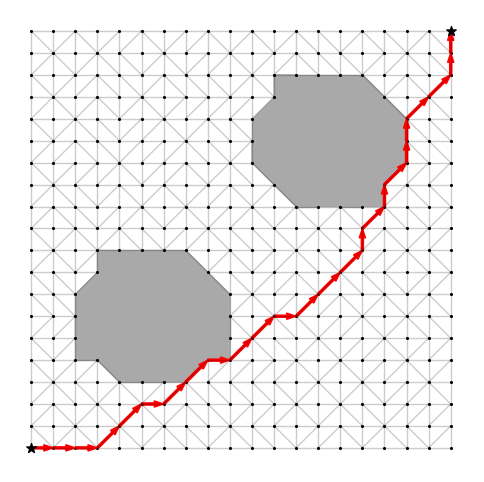

In [4]:
start, end = 0, len(SC.node_vec)-1
path1_coords = [(-1,-1), (0,-1), (0,0), (1, 0), (1,1)]
num_paths, num_nodes = 1, 1

extra = True
shortest_path, _, _, _, _ = augmented_dijkstra(SC, start, end, np.zeros(n_holes), False, extra)
shortest_path_coords = [SC.nodes[u] for u in shortest_path.nodes]

shortest_path_class = Trajectory_Class(SC, extra)
shortest_path_class.generate_paths(shortest_path_coords, 1, 1, 0)
shortest_path = shortest_path_class.paths[0]
 
shortest_path_class.plot_paths('red', 'shortest')
ref_path_proj = shortest_path.edge_projections[-1]

In [ ]:
ref_path_proj

In [ ]:
shortest_path_class.plot_projections('red', 'reference', figsize=(5,5))

In [ ]:
start, end = 0, len(SC.node_vec)-1

alphas = [0, 1, 5, 10, 100]
holders = []

for alpha in alphas:
    print("--*---*"*20)
    best_path, cost, prev, visit_order, other_paths = augmented_dijkstra(SC, start, end, ref_path_proj, alpha, extra)
    print(f"Alpha = {alpha},  final cost = {cost}")
    print(f"ref proj : {ref_path_proj}, path proj : {best_path.edge_projections[-1]}")
    holder = dijkstra_tree(SC, best_path, other_paths, shortest_path_class)
    plot_cost_diffs(shortest_path, best_path, ref_path_proj, alpha)
    holders.append(holder)


# Extra = True

In [ ]:
start, end = 0, len(SC.node_vec)-1
path1_coords = [(-1,-1), (0,-1), (0,0), (1, 0), (1,1)]
num_paths, num_nodes = 1, 1
extra = True

shortest_path, _, _, _, _ = augmented_dijkstra(SC, start, end, np.zeros(n_holes), 0, extra)
shortest_path_coords = [SC.nodes[u] for u in shortest_path.nodes]

shortest_path_class = Trajectory_Class(SC, extra)
shortest_path_class.generate_paths(shortest_path_coords, 1, 1, 0)
shortest_path_class.plot_paths('red', 'shortest')
ref_path_proj = shortest_path.edge_projections[-1]

In [ ]:
start, end = 0, len(SC.node_vec)-1

alphas = [0, 1, 5, 10, 100]
holders = []

for alpha in alphas:
    print("--*---*"*20)
    best_path, cost, prev, visit_order, other_paths = augmented_dijkstra(SC, start, end, ref_path_proj, alpha, extra)
    print(best_path.edge_projections[-1])
    print(f"Alpha = {alpha},  final cost = {cost}")
    print(f"ref proj : {ref_path_proj}, path proj : {best_path.edge_projections[-1]}")
    holder = dijkstra_tree(SC, best_path, other_paths, shortest_path_class)
    plot_cost_diffs(shortest_path, best_path, ref_path_proj, alpha)
    holders.append(holder)


# Drawing example

In [ ]:
n_side, point_gen_mode = 20, 0

r1, r2 = 0.6, 0.3
n_holes = 2
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]
hole_locs += np.array([0.0, 0.05])

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0
start, end = 0, len(SC.node_vec)-1

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
plt.figure(figsize=(12,12))
SC.plot()

In [ ]:
plot_bases(SC, False)

In [ ]:
ref_path_coords = [(-1,-1), (0, -1), (0, 1), (1,1)]
num_paths, num_nodes = 1, 1

start, end = 0, len(SC.node_vec)-1

#ref_path, _, _, _, _ = augmented_dijkstra(SC, start, end, np.zeros(2), 0)
#ref_path_class = Trajectory_Class(SC)
#ref_path_class.add_path(ref_path)
#ref_path_class.plot_paths('red', 'reference', figsize=(12,12))
#ref_path_proj = ref_path.edge_projections[-1]

ref_path_class = Trajectory_Class(SC)
ref_path_class.generate_paths(ref_path_coords, num_paths, num_nodes, 1e-1)
ref_path = ref_path_class.paths[0]
ref_path_class.plot_paths('red', 'ref', figsize=(12,12))
ref_path_proj = ref_path.edge_projections[-1]
ref_path_class.plot_projections('red', 'reference', figsize=(12,12))

In [ ]:
start, end = 0, len(SC.node_vec)-1

alphas = [0, 0.1, 0.3, 0.5, 1, 1.5, 5, 100]
holders = []

for alpha in alphas:
    print("--*---*"*20)
    best_path, cost, prev, visit_order, other_paths = augmented_dijkstra(SC, start, end, ref_path_proj, alpha, False)
    print(f"Alpha = {alpha},  final cost = {cost}")
    print(f"ref proj : {ref_path_proj}, path proj : {best_path.edge_projections[-1]}")
    holder = dijkstra_tree(SC, best_path, other_paths, ref_path_class)
    plot_cost_diffs(ref_path, best_path, ref_path_proj, alpha)
    holders.append(holder)
